### Step 3

# Create geological model

In [3]:
import sys, warnings
warnings.filterwarnings('ignore')
import numpy as np
import gempy as gp # importing gempy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [4]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        resolution=[50, 50, 50], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")



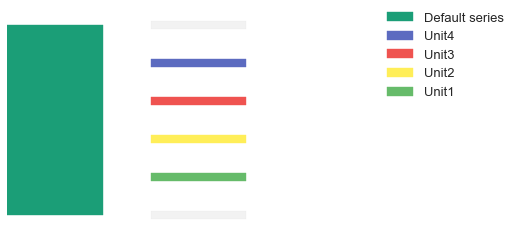

In [5]:
orderf = ["Unit4", "Unit3", "Unit2", "Unit1"]

gp.set_series(geo_data, {"Default series": np.unique(geo_data.interfaces["formation"].values)},
             order_formations = orderf)
gp.set_order_formations(geo_data, orderf)

#### Data visualization

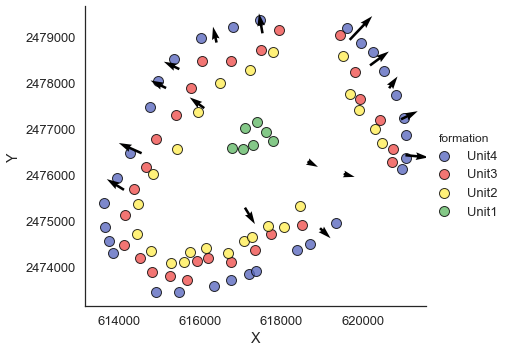

In [6]:
gp.plot_data(geo_data, direction="z")

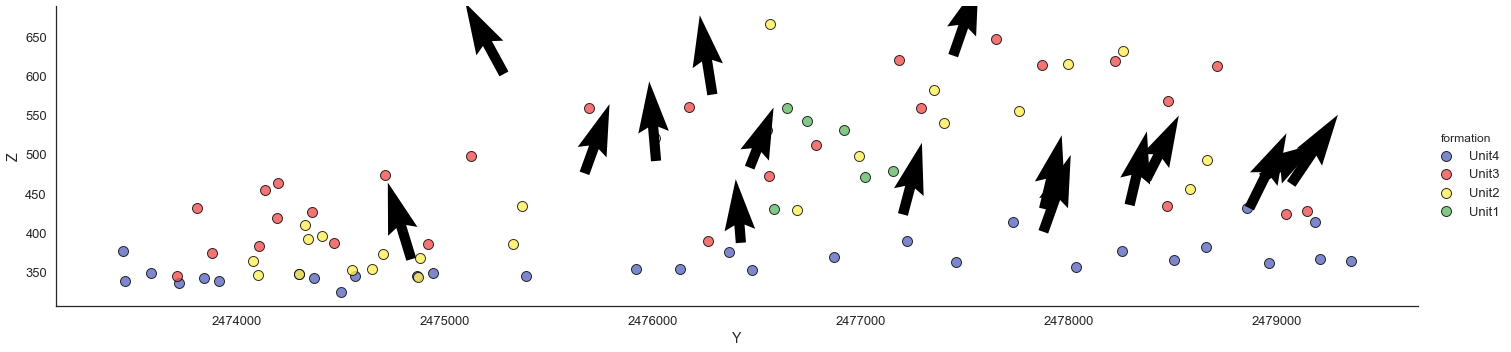

In [7]:
gp.plot_data(geo_data, direction="x")

0     621055.284454
1     620946.810298
2     620653.973690
3     615165.009653
4     615490.574975
5     614562.705647
6     614128.758702
7     618954.185116
8     619535.625878
9     616406.887377
10    616103.856828
11    617537.992479
12    619683.550025
13    620183.977449
14    617105.587985
15    618645.592616
Name: X, dtype: float64

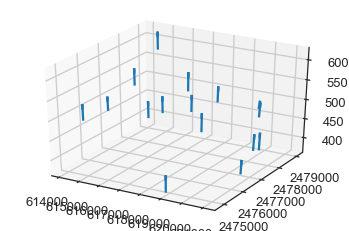

In [16]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.quiver(geo_data.foliations["X"], 
          geo_data.foliations["Y"], 
          geo_data.foliations["Z"], 
          geo_data.foliations["G_x"], 
          geo_data.foliations["G_y"], 
          geo_data.foliations["G_z"], length=50, normalize=True)

plt.show()

In [8]:
geo_data.foliations

,X,Y,Z,dip,azimuth,polarity,formation,series,order_series,isFault,formation number,annotations,G_x,G_y,G_z
0,621055.284454,2.476424e+06,386.818182,40.669425,95.415167,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},0}$",0.648785,-0.061502,0.758482
1,620946.810298,2.477202e+06,422.923077,31.267317,64.093066,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},1}$",0.466871,0.226770,0.854755
2,620653.973690,2.477877e+06,400.820896,23.686789,35.631571,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},2}$",0.234040,0.326523,0.915755
3,615165.009653,2.477880e+06,430.000000,28.747494,295.927864,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},3}$",-0.432540,0.210290,0.876748
4,615490.574975,2.478291e+06,435.000000,28.593829,295.542510,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},4}$",-0.431822,0.206362,0.878035
5,614562.705647,2.476466e+06,482.600000,44.203331,294.162820,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},5}$",-0.636122,0.285388,0.716870
6,614128.758702,2.475672e+06,475.375000,34.435457,301.867328,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},6}$",-0.480245,0.298546,0.824764
7,618954.185116,2.474840e+06,365.833333,23.871344,133.686261,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},7}$",0.292640,-0.279519,0.914456
8,619535.625878,2.476016e+06,491.125000,18.457026,104.880962,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},8}$",0.305975,-0.081305,0.948561
9,616406.887377,2.478867e+06,431.000000,26.923954,347.390550,1,Unit1,Default series,1,False,4,"${\bf{x}}_{\beta \,{\bf{4}},9}$",-0.098850,0.441886,0.891608


#### Computing the 3D Model

In [266]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32", u_grade=[3])

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [267]:
lith_block, fault_block = gp.compute_model(interp_data)

### Step 4

## Post-processing results for visualization and interpretation

#### 2D Sections

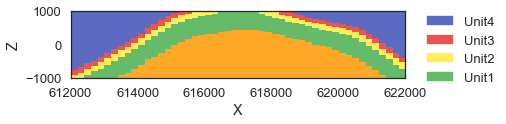

In [268]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y', plot_data=False)

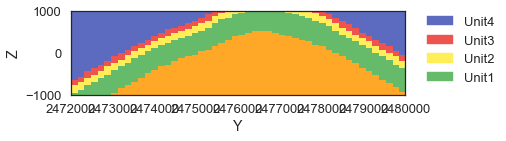

In [269]:
gp.plot_section(geo_data, lith_block[0], 25, direction='x', plot_data=False)

#### Pseudo-3D surfaces

In [270]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)

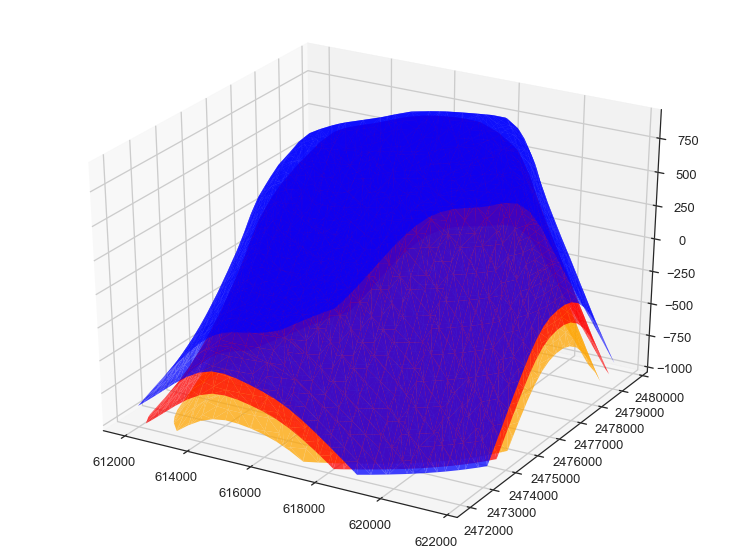

In [271]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

cs = ["blue", "red", "orange"]



for i in range(3):
    surf = ax.plot_trisurf(v_l[i][:,0], v_l[i][:,1], v_l[i][:,2], 
                           color=cs[i], linewidth=0, alpha=0.75, shade=False)

#### 3D Visualization using VTK

<div class="alert alert-danger">
**Important note**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [272]:
gp.plot_surfaces_3D(geo_data, v_l, s_l)

#### Exporting a geological map

In [273]:
import gdal
geotiff_filepath = "../data/dome_sub_sub_utm.tif"
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()

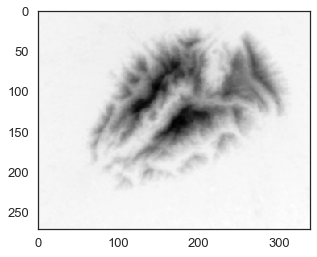

In [274]:
import matplotlib.pyplot as plt
plt.imshow(dtm)
plt.show()

In [275]:
# here are the raster dimensions:
raster.RasterXSize, raster.RasterYSize
geoinformation = raster.GetGeoTransform()

get DTM corners:


In [276]:
dtm_E_min = geoinformation[0]
dtm_E_max = geoinformation[0] + geoinformation[1] * raster.RasterXSize
dtm_N_min = geoinformation[3] + geoinformation[5] * raster.RasterYSize
dtm_N_max = geoinformation[3]
dtm_E_min, dtm_E_max, dtm_N_min, dtm_N_max

(612000.0, 622000.0, 2472000.0, 2480000.0)

In [277]:
# define range for x, y - values
X_range = np.arange(dtm_E_min, dtm_E_max, geoinformation[1])
Y_range = np.arange(dtm_N_min, dtm_N_max, np.abs(geoinformation[5]))
XX, YY = np.meshgrid(X_range, Y_range)

Create list of input points for interpolation with gempy:

In [278]:
points = np.array(list(zip(XX.ravel(), YY.ravel(), dtm.ravel())))

In [279]:
points

array([[  6.12000000e+05,   2.47200000e+06,   3.38000000e+02],
       [  6.12029499e+05,   2.47200000e+06,   3.34000000e+02],
       [  6.12058997e+05,   2.47200000e+06,   3.34000000e+02],
       ..., 
       [  6.21911504e+05,   2.47997048e+06,   2.99000000e+02],
       [  6.21941003e+05,   2.47997048e+06,   2.97000000e+02],
       [  6.21970501e+05,   2.47997048e+06,   2.99000000e+02]])

Build basic gempy using _data_ extent (_resolution_ does not matter, as far as I can tell):

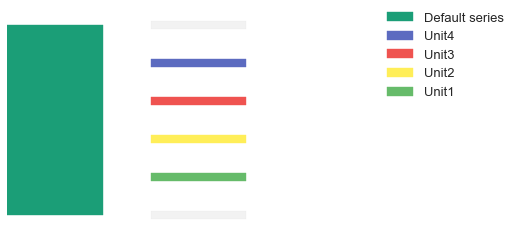

In [280]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000],  
                        resolution=[1, 1, 1], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

gp.set_series(geo_data, {"Default series": np.unique(geo_data.interfaces["formation"].values)},
             order_formations = orderf)

gp.set_order_formations(geo_data, orderf)

Now here the "trick": replace grid points with DTM grid points:

In [281]:
geo_data.grid.grid = points

Perform the "usual" interpolation step:

In [282]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32")
lith_block, fault_block = gp.compute_model(interp_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


And here: **the geological map**:

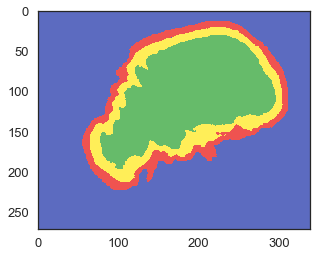

In [286]:
geo_map = lith_block[0].copy().reshape((271,339))
# adjust scale
geo_map += 1
# adjust misfits:
geo_map[np.where(geo_map==5)] = 1
geo_map[np.where(geo_map==6)] = 2
geo_map[np.where(geo_map==7)] = 3
geo_map[np.where(geo_map==8)] = 4
geo_map[np.where(geo_map==1)] = 5
geo_map -= 1
# change to int for later use:
geo_map = geo_map.astype('int16')
# adjust orientation:
geo_map = geo_map[::-1,:]
plt.imshow(geo_map, cmap=gp.colors.cmap, norm=gp.colors.norm)
# plt.colorbar()

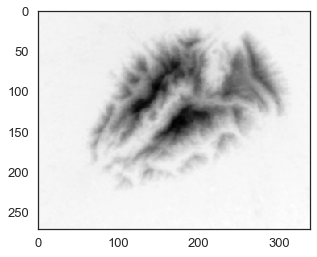

In [284]:
import matplotlib.pyplot as plt
plt.imshow(dtm)
plt.show()

In [285]:
np.min(dtm), np.max(dtm)

(289, 781)

In [25]:
file = geotiff_filepath
outFileName = "/data/geomap.tif"
# transform data
# geo_map = geo_map.astype('int16')
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
# arr_min = arr.min()
# arr_max = arr.max()
# arr_mean = int(arr.mean())
# arr_out = np.where((arr < arr_mean), 10000, arr)
driver = gdal.GetDriverByName("GTiff")
# options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF']
options = ['PROFILE=GeoTiff', 'PHOTOMETRIC=RGB', 'COMPRESS=JPEG']
# outdata = driver.Create(outFileName, rows, cols, 3, gdal.GDT_UInt16, options=options)
outdata = driver.Create(outFileName, rows, cols, 3, gdal.GDT_Byte, options=options)


outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(geo_map*64)
outdata.GetRasterBand(2).WriteArray(geo_map*64)
outdata.GetRasterBand(3).WriteArray(geo_map*64)
# outdata.GetRasterBand(4).WriteArray(np.ones_like(geo_map)*100)
outdata.GetRasterBand(1).SetColorInterpretation(gdal.GCI_RedBand)
outdata.GetRasterBand(2).SetColorInterpretation(gdal.GCI_GreenBand)
outdata.GetRasterBand(3).SetColorInterpretation(gdal.GCI_BlueBand)
# outdata.GetRasterBand(4).SetColorInterpretation(gdal.GCI_AlphaBand)


# outdata.GetRasterBand(1).SetNoDataValue(999)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

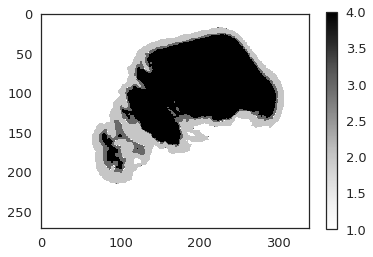

In [26]:
plt.imshow(geo_map)
geo_map[np.where(geo_map == 0)] = 10
plt.colorbar()
plt.show()

In [27]:
arr.dtype

dtype('int16')

In [28]:
geo_map.dtype

dtype('int16')

In [29]:
ds = gdal.Open(file)

In [30]:
ds.GetRasterBand

<bound method Dataset.GetRasterBand of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f3fd020ed80> >>

In [31]:
np.min(geo_map), np.max(geo_map*64)

(1, 256)